### Importing the Dependencies

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os 
import mlflow
import mlflow.sklearn
import logging
import time
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import dagshub
import numpy as np

### Data Collection

In [4]:
calories = pd.read_csv('calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [5]:
exercise_data = pd.read_csv('exercise.csv')
exercise_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


#### Combining the two Dataframes

In [6]:
#Merging two datasets using User_ID
calories_data = exercise_data.merge(calories, on="User_ID")
calories_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [7]:
#Check final dataset
calories_data.shape

(15000, 9)

In [8]:
#Check dataset info 
calories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


### Processing

#### Check for missing values

In [9]:
calories_data.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

#### Encode gender column that is object type

In [10]:
le = LabelEncoder()
calories_data['Gender'] = le.fit_transform(calories_data['Gender'])

#### Statistical summary

In [11]:
calories_data.describe()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,0.496467,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,0.500004,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,0.000000,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,0.000000,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,1.000000,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


- We can see down bellow that regarding gender we have almost balanced dataset with pretty equal man and women group. 

- Ages vary from 20 years old to 79 years old with median 39 years old that indicate mix of young and older adults skewing little bit towards middle aged patients

- The wide standard deviation in height and weight suggest diversity in body types 

- I verified there were no missing values in the dataset based on consistent counts across all columns

- The calorie burn shows a high standard deviation, so I might explore normalization or binning for modeling

- Heart rate and body temp being correlated with duration could be interesting for feature engineering or predictive modeling

- Outliers are possible — for example, 1 minute duration or 314 calories — I’d visualize this with boxplots or histograms

#### Plot gender

<Axes: xlabel='Gender', ylabel='count'>

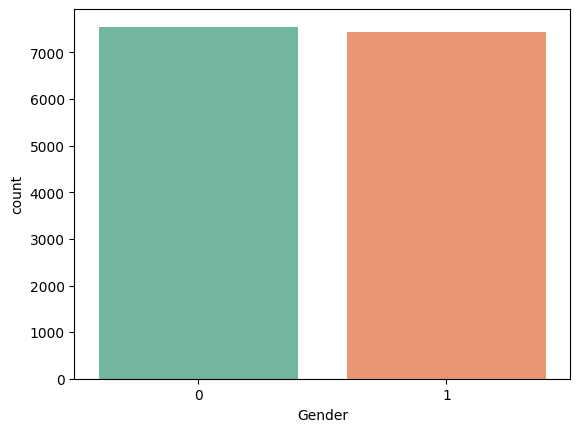

In [12]:
sns.countplot(data=calories_data, x='Gender', hue='Gender', palette='Set2', legend=False)

<Axes: xlabel='Age', ylabel='Count'>

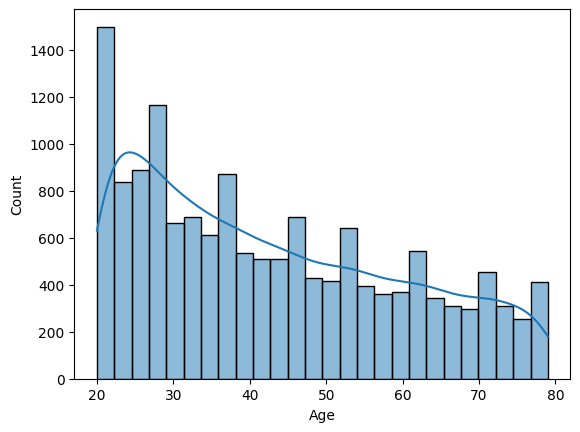

In [13]:
###Check distributions for age,weight and Height
sns.histplot(calories_data['Age'], kde=True)

<Axes: xlabel='Height', ylabel='Count'>

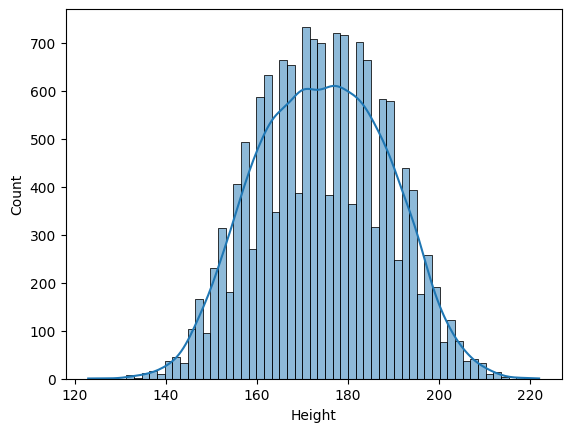

In [14]:
sns.histplot(calories_data['Height'], kde=True)

<Axes: xlabel='Weight', ylabel='Count'>

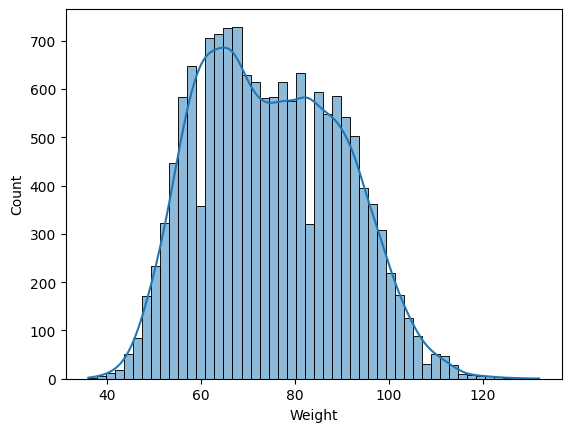

In [15]:
sns.histplot(calories_data['Weight'], kde=True)

#### CORELATION HEATMAP

- Shows how strongly features are linearly correlated 

- Helps detect multicollinearity and strongest predictors of Calories

Feature correlation with Calories:
 Calories      1.000000
Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Gender        0.022357
Height        0.017537
User_ID      -0.001661
Name: Calories, dtype: float64


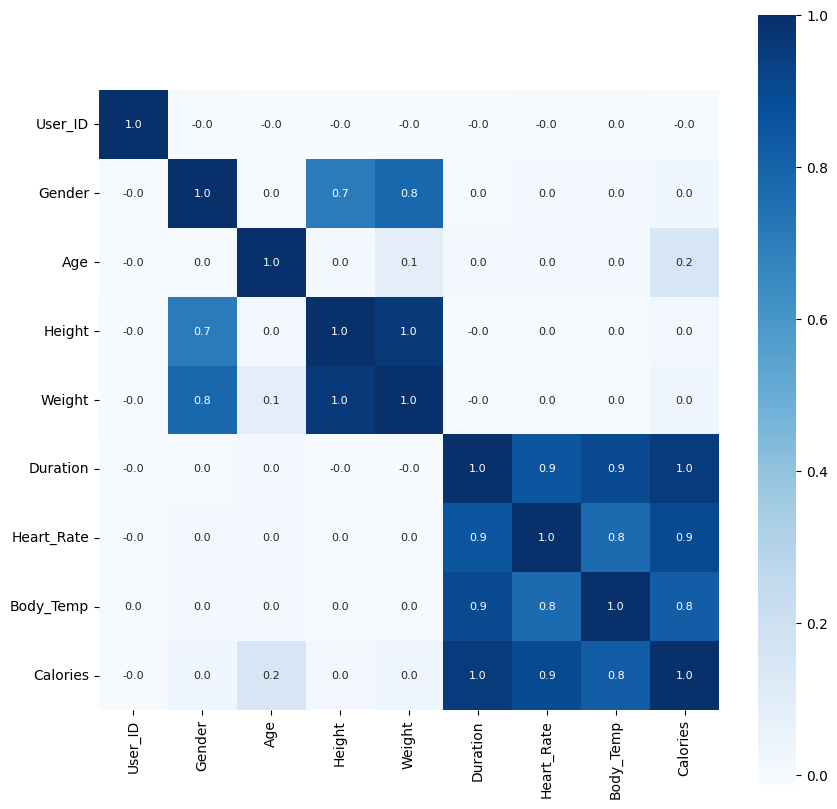

In [16]:
correlation = calories_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')
corr_target = correlation['Calories'].sort_values(ascending=False)
print("Feature correlation with Calories:\n", corr_target)

### Feature target split

In [17]:
#User_ID excluded, not predictive
X = calories_data.drop(columns=['User_ID', 'Calories'], axis=1)
Y = calories_data['Calories']

### Train-Test split 

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

### Create model 

In [21]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# (Optional) DAGsHub tracking URI – replace with your actual URI
mlflow.set_tracking_uri("https://dagshub.com/vucina19931906/Calories-Burnt-Predictor.mlflow")
dagshub.init(repo_owner='vucina19931906', repo_name='Calories-Burnt-Predictor', mlflow=True)

mlflow.set_experiment("Calories-Burnt-Predictor")

logging.info("Starting MLflow run...")

with mlflow.start_run(run_name="xgboost-base-model"):
    start_time = time.time()

    try:
        logging.info("Initializing XGBoost Regressor with base parameters...")
        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        )

        logging.info("Fitting the model on training data...")
        model.fit(X_train, Y_train)
        logging.info("Model training complete.")

        logging.info("Making predictions on test data...")
        preds = model.predict(X_test)

        logging.info("Calculating evaluation metrics...")
        mae = mean_absolute_error(Y_test, preds)
        rmse = np.sqrt(mean_squared_error(Y_test, preds))
        r2 = r2_score(Y_test, preds)

        logging.info("Logging model parameters and metrics to MLflow...")
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({
            "mae": mae,
            "rmse": rmse,
            "r2_score": r2
        })

        logging.info("Saving and logging the trained model artifact...")
        mlflow.sklearn.log_model(model, "xgboost_model")

        end_time = time.time()
        logging.info(f"Training and logging completed in {end_time - start_time:.2f} seconds.")

        logging.info(f"MAE: {mae:.4f}")
        logging.info(f"RMSE: {rmse:.4f}")
        logging.info(f"R²: {r2:.4f}")

    except Exception as e:
        logging.error(f"An error occurred during MLflow logging: {e}", exc_info=True)



2025-04-06 18:22:48,597 - INFO - HTTP Request: GET https://dagshub.com/api/v1/repos/vucina19931906/Calories-Burnt-Predictor "HTTP/1.1 200 OK"


Initialized MLflow to track repo "vucina19931906/Calories-Burnt-Predictor"

2025-04-06 18:22:48,605 - INFO - Initialized MLflow to track repo "vucina19931906/Calories-Burnt-Predictor"


Repository vucina19931906/Calories-Burnt-Predictor initialized!

2025-04-06 18:22:48,609 - INFO - Repository vucina19931906/Calories-Burnt-Predictor initialized!
2025-04-06 18:22:48,870 - INFO - Starting MLflow run...
2025-04-06 18:22:49,113 - INFO - Initializing XGBoost Regressor with base parameters...
2025-04-06 18:22:49,124 - INFO - Fitting the model on training data...
2025-04-06 18:22:49,818 - INFO - Model training complete.
2025-04-06 18:22:49,820 - INFO - Making predictions on test data...
2025-04-06 18:22:49,846 - INFO - Calculating evaluation metrics...
2025-04-06 18:22:49,853 - INFO - Logging model parameters and metrics to MLflow...
2025-04-06 18:22:50,338 - INFO - Saving and logging the trained model artifact...
2025/04/06 18:22:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-06 18:23:00,341 - INFO - Training and logging completed in 11.23 seconds.
2025-04-06 18:23:00,344 - INFO - MAE: 0.9441
2025-04

🏃 View run xgboost-base-model at: https://dagshub.com/vucina19931906/Calories-Burnt-Predictor.mlflow/#/experiments/0/runs/a60d39bd3b7847248493ef355e7abc2d
🧪 View experiment at: https://dagshub.com/vucina19931906/Calories-Burnt-Predictor.mlflow/#/experiments/0
